In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv('data/port_distances.csv')
df.columns = ['from', 'to', 'distance']
print(df.head())

      from         to  distance
0   AAHEIM     HALDIA   8652.67
1   AAHEIM  PARANAGUA   6304.48
2   AAHEIM  ROTTERDAM    699.72
3  AALBORG      TAMPA   4447.90
4   AARHUS    ANTWERP    651.84


In [3]:
# Build graph of distances
mp = {}
adj = [[0 for i in range(1949)] for j in range(1949)]
for i, (a, b, c) in df.iterrows():
    if a not in mp: mp[a] = len(mp)
    if b not in mp: mp[b] = len(mp)
    adj[mp[a]][mp[b]] = c

for i in range(1949):
    for j in range(1949):
        if adj[j][i] == 0:
            adj[j][i] = adj[i][j]

from scipy.sparse import coo_matrix

adj = coo_matrix(np.array(adj), shape=(len(mp), len(mp)))

from scipy.sparse.csgraph import dijkstra


def get_distance(src, dst):
    return dijkstra(csgraph=adj, directed=True, indices=mp[src])[mp[dst]]

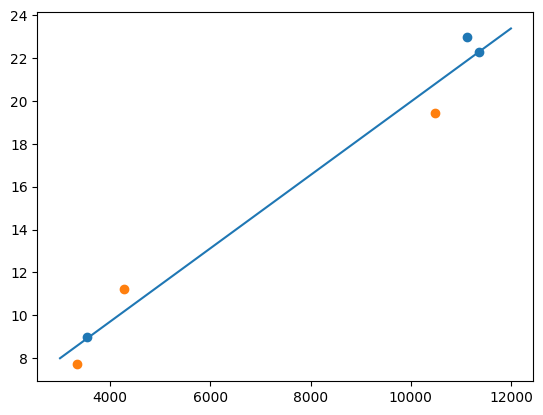

In [4]:
# Estimate freight rate based on distance of route, using the committed cargos and baltic exchange FFA rates for C3, C5 and C7 routes
a1 = [('KAMSAR ANCHORAGE', 'QINGDAO'), ("PORT HEDLAND", 'LIANYUNGANG'), ('ITAGUAI', 'QINGDAO')]
a2 = [('TUBARAO', 'QINGDAO'), ('DAMPIER', 'QINGDAO'), ('PUERTO BOLIVAR (COLOMBIA)', 'ROTTERDAM')]

x1 = [get_distance(i, j) for (i, j) in a1]
x2 = [get_distance(i, j) for (i, j) in a2]

y1 = [23, 9, 22.3]
y2 = [19.45, 7.7, 11.21]

from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(np.array(x1 + x2).reshape(-1, 1), y1 + y2)
m, c = lm.coef_[0], lm.intercept_

import matplotlib.pyplot as plt

plt.scatter(x1, y1)
plt.scatter(x2, y2)
x = np.linspace(3000, 12000, 100)
y = m * x + c
plt.plot(x, y)
plt.show()

In [5]:
# Classes to handle TCE calculation
class Ship:
    def __init__(self, data):
        self.ballast_eco_spd = data['Economical Speed Ballast (kn)']
        self.ballast_max_spd = data['Warranted Speed Ballast (kn)']
        self.laden_eco_spd = data['Economical Speed Laden (kn)']
        self.laden_max_spd = data['Warranted Speed Laden (kn)']
        self.ballast_eco_vlsf = data['Economical Speed Ballast VLSF (mt)']
        self.ballast_eco_mgo = data['Economical Speed Ballast MGO (mt)']
        self.ballast_max_vlsf = data['Warranted Speed Ballast VLSF (mt)']
        self.ballast_max_mgo = data['Warranted Speed Ballast MGO (mt)']
        self.laden_eco_vlsf = data['Economical Speed Laden VLSF (mt)']
        self.laden_eco_mgo = data['Economical Speed Laden MGO (mt)']
        self.laden_max_vlsf = data['Warranted Speed Laden VLSF (mt)']
        self.laden_max_mgo = data['Warranted Speed Laden MGO (mt)']
        self.port_working_mgo = data['Port Consumption Working MGO (mt/day)']
        self.port_idle_mgo = data['Port Consumption Idle MGO (mt/day)']
        self.dwt = data['DWT (MT)']
        self.hire_rate = data['Hire Rate (USD/day)']
        self.location = data['Discharge Port']
        self.discharge_date = datetime.strptime(data['ETD'], '%d/%m/%Y').date()
        self.discharge_vlsf_price = 500
        self.discharge_mgo_price = 650
        self.vlsf_left = data['Bunker Remaining VLSF (mt)']
        self.mgo_left = data['Bunker Remaining MGO (mt)']


class Cargo:
    def __init__(self, data, market=False):
        self.qty = data['Quantity']
        self.loadport = data['Load Port']
        self.disport = data['Discharge Port']
        self.laycan_start = datetime.strptime(data['Laycan Start'], '%d/%m/%Y').date()
        self.laycan_end = datetime.strptime(data['Laycan End'], '%d/%m/%Y').date()
        self.load_rate = data['Loading Terms (MT)']
        self.discharge_rate = data['Discharge Terms (MT)']
        self.load_tt = data['Loading Terms Turn Time']
        self.discharge_tt = data['Discharge Terms Turn Time']
        self.port_cost = data['Port Cost']
        self.brkcoms = data['Commission'] if data['Commission To'] == 'broker' else 0
        self.adcoms = data['Commission'] if data['Commission To'] == 'charterer' else 0
        self.laden_dist = get_distance(self.loadport, self.disport)
        self.freight_rate = m * self.laden_dist + c if market else data['Freight Rate ($/MT)']
        self.loadport_vlsf_price = 500
        self.loadport_mgo_price = 650
        self.disport_vlsf_price = 500
        self.disport_mgo_price = 650

    def loadport_days(self):
        return self.qty / self.load_rate + self.load_tt / 24

    def disport_days(self):
        return self.qty / self.discharge_rate + self.discharge_tt / 24

    def total_revenue(self):
        return self.qty * self.freight_rate


class TCECalculator:
    def __init__(self, ship, cargo):
        self.ship = ship
        self.cargo = cargo
        self.ballast_dist = get_distance(ship.location, cargo.loadport)
        self.laden_dist = cargo.laden_dist
        self.total_days = 0

    def ballast_fuel_cost(self, state, days):
        if state == 'eco':
            return days * (
                    self.ship.ballast_eco_vlsf * self.ship.discharge_vlsf_price + self.ship.ballast_eco_mgo * self.ship.discharge_mgo_price)
        else:
            return days * (
                    self.ship.ballast_max_vlsf * self.ship.discharge_vlsf_price + self.ship.ballast_max_mgo * self.ship.discharge_mgo_price)

    def laden_fuel_cost(self, state, days):
        if state == 'eco':
            return days * (
                    self.ship.laden_eco_vlsf * self.cargo.loadport_vlsf_price + self.ship.laden_eco_mgo * self.cargo.loadport_mgo_price)
        else:
            return days * (
                    self.ship.laden_max_vlsf * self.cargo.loadport_vlsf_price + self.ship.laden_max_mgo * self.cargo.loadport_mgo_price)

    def sea_fuel_costs(self):
        """
        Calculates the fuel costs required to meet the laycan date. There are 4 possible options, as we can choose to sail at the economical speed or warranted speed for each of the ballast or laden parts of the journey.
        :return: A list of the fuel cost and travel duration representing [(eco,eco), (eco,max), (max,eco), (max,max)]. (np.inf, np.inf) if it is not possible to meet the laycan.
        """
        ballast_eco_days = self.ballast_dist / (self.ship.ballast_eco_spd * 24)
        ballast_max_days = self.ballast_dist / (self.ship.ballast_max_spd * 24)
        laden_eco_days = self.laden_dist / (self.ship.laden_eco_spd * 24)
        laden_max_days = self.laden_dist / (self.ship.laden_max_spd * 24)
        max_ballast_time = (self.cargo.laycan_end - self.ship.discharge_date).days
        min_ballast_time = (self.cargo.laycan_start - self.ship.discharge_date).days
        ballast_eco_days = max(ballast_eco_days, min_ballast_time)
        ballast_max_days = max(ballast_max_days, min_ballast_time)

        return [
            (self.ballast_fuel_cost('eco', ballast_eco_days) + self.laden_fuel_cost('eco', laden_eco_days),
             ballast_eco_days + laden_max_days) if ballast_eco_days <= max_ballast_time else (np.inf, np.inf),

            (self.ballast_fuel_cost('eco', ballast_eco_days) + self.laden_fuel_cost('max', laden_max_days),
             ballast_eco_days + laden_max_days) if ballast_eco_days <= max_ballast_time else (np.inf, np.inf),

            (self.ballast_fuel_cost('max', ballast_max_days) + self.laden_fuel_cost('eco', laden_eco_days),
             ballast_max_days + laden_eco_days) if ballast_max_days <= max_ballast_time else (np.inf, np.inf),

            (self.ballast_fuel_cost('max', ballast_max_days) + self.laden_fuel_cost('max', laden_max_days),
             ballast_max_days + laden_max_days) if ballast_max_days <= max_ballast_time else (np.inf, np.inf),
        ]

    def port_fuel_costs(self):
        return self.cargo.loadport_days() * self.ship.port_working_mgo * self.cargo.loadport_mgo_price

    def total_costs(self):
        sea_fuel_costs, steaming_days = self.sea_fuel_costs()
        self.total_days = max(steaming_days + self.cargo.loadport_days() + self.cargo.disport_days(),
                              (self.cargo.laycan_start - self.ship.discharge_date).days)
        return sea_fuel_costs + self.port_fuel_costs() + self.total_days * self.ship.hire_rate * (
                1 - self.cargo.adcoms) + self.cargo.port_cost

    def calculate_TCE(self):
        best_TCE = 0
        for (sea_fuel_cost, steaming_days) in self.sea_fuel_costs():
            if sea_fuel_cost == np.inf: continue
            total_days = steaming_days + self.cargo.loadport_days() + self.cargo.disport_days()
            total_cost = sea_fuel_cost + self.port_fuel_costs() + self.cargo.port_cost + total_days * self.ship.hire_rate * (
                        1 - self.cargo.adcoms)
            current_TCE = (self.cargo.total_revenue() - total_cost) / total_days
            if current_TCE > best_TCE:
                best_TCE = current_TCE
                self.total_days = total_days
        return best_TCE

    def arrival_date(self):
        return self.ship.discharge_date + self.total_days

In [6]:
# Load data into classes
cargill_vessels = [Ship(row) for i, row in pd.read_csv('data/cargill_capesize_vessels.csv').iterrows()]
market_vessels = [Ship(row) for i, row in pd.read_csv('data/market_vessels.csv').iterrows()]
for vessel in market_vessels:
    vessel.hire_rate = 15000
cargill_cargos = [Cargo(row) for i, row in pd.read_csv('data/cargill_committed_cargoes.csv').iterrows()]
market_cargos = [Cargo(row, market=True) for i, row in pd.read_csv('data/market_cargoes.csv').iterrows()]

calculators = [[TCECalculator(ship, cargo) for cargo in cargill_cargos + market_cargos] for ship in
               cargill_vessels + market_vessels]

tce = [[round(calculator.calculate_TCE(), 2) for calculator in ls] for ls in calculators]

KeyError: 'Port Consumption Working MGO (mt/day)'

In [ ]:
from tabulate import tabulate

print(tabulate(tce, headers=range(len(tce[0])), tablefmt='grid'))

+---------+---------+---------+----------+---------+---------+-----+---------+---------+----------+----------+
|       0 |       1 |       2 |        3 |       4 |       5 |   6 |       7 |       8 |        9 |       10 |
+=========+=========+=========+==========+=========+=========+=====+=========+=========+==========+==========+
| 17606   | 6013.76 | 15030.6 |  7411.76 | 17322.6 | 13121.2 |   0 | 6591.86 |  627.07 | 10860    | 11711    |
+---------+---------+---------+----------+---------+---------+-----+---------+---------+----------+----------+
| 14083.3 | 4393.7  | 13188   |  8676.27 | 14812.6 |     0   |   0 | 1229.98 |    0    | 10076.8  |  7341.28 |
+---------+---------+---------+----------+---------+---------+-----+---------+---------+----------+----------+
|     0   |    0    |     0   |     0    |     0   |     0   |   0 | 8381.18 |    0    |     0    |     0    |
+---------+---------+---------+----------+---------+---------+-----+---------+---------+----------+----------+
|

In [33]:
# Find optimal assignment to maximize profit
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(tce, maximize=True)

for i in range(len(row_ind)):
    if tce[row_ind[i]][col_ind[i]]:
        print(f'Vessel {row_ind[i]} {"(Cargill)" if row_ind[i] < 4 else "(Market)"} should carry cargo {col_ind[i]} with a TCE of {tce[row_ind[i]][col_ind[i]]}')

Vessel 0 (Cargill) should carry cargo 1 with a TCE of 6013.76
Vessel 1 (Cargill) should carry cargo 9 with a TCE of 10076.75
Vessel 3 (Cargill) should carry cargo 8 with a TCE of 3109.81
Vessel 4 (Market) should carry cargo 0 with a TCE of 18175.19
Vessel 6 (Market) should carry cargo 4 with a TCE of 20073.92
Vessel 7 (Market) should carry cargo 3 with a TCE of 12551.13
Vessel 8 (Market) should carry cargo 5 with a TCE of 22590.94
Vessel 9 (Market) should carry cargo 10 with a TCE of 23604.46
Vessel 10 (Market) should carry cargo 7 with a TCE of 8578.69
Vessel 13 (Market) should carry cargo 2 with a TCE of 18564.83
